# Simulation of Most Permissive Boolean networks

The module `mpbn.simulation` implements random walks into the Most Permissive (MP) dynamics of a given Boolean networks, for estimating the stationnary distribution.

The method is described in the paper [Variable-Depth Simulation of Most Permissive Boolean Networks](https://hal.archives-ouvertes.fr/hal-03704761/file/cmsb22.pdf) by Roncalli et al. (2022).
The random walk is performed from a given initial configurations and transition probabilies are computed according to two parameters:
- the *permissivity depth* of the transition, where depth 1 corresponds to asynchronous transitions, and further depth characterize the transitions that require permissive interpretation of transitions.
- the numer of components that change of value in one transition.
The parametrization allow scaling the probability of the transition as a function of these two quantities.

This notebook demonstrates how to use to employ the `mpbn.simulation` module. Alternatively, the simulations can be performed using the command line utility `mpbn-sim`. See `mpbn-sim --help` for usage, and https://github.com/bnediction/mpbn/tree/master/examples for examples of configuration files (e.g., [simulation_bladder.json](https://github.com/bnediction/mpbn/blob/master/examples/simulation_bladder.json) and [simulation_i3ffl2.json](https://github.com/bnediction/mpbn/blob/master/examples/simulation_i3ffl2.json) files).

Simulations are performed with `estimate_reachable_attractors_probabilities` and `parallel_estimate_reachable_attractors_probabilities` functions. These functions require

- a Boolean network `f`, being either a `mpbn.MPBooleanNetwork` object or any object supported by its constructor (e.g., `colomini.minibn.BooleanNetwork` object, Python dictionnary, filename in BoolNet format, GINsim or bioLQM objects)
- an initial configuration `x`, being a dictionnary associating components to a Boolean value
- a list `A` of attractors reachable from `x`, as obtained with `f.attractors(reachable_from=init)` provided that `f` is a `mpbn.MPBooleanNetwork` object
- a number `nb_sims` of trajectories to simulate
- a function `depth()` which is called at each simulation step to determine the maximum permissivity depth of transitions to consider
- a vector `W` of `n` reals (where `n` is the number of components of `f`) for determining the rate of a transition in function of the number of components that change of value.

The simulation returns a dictionnary associating the index of the attrarctor in `A` with its estimated stationnary probability.

The function for the `depth` parameter can be generated using:
- `constant_maximum_depth(f)`: consider all MP transitions for the BN `f`
- `constant_unitary_depth(f)`: consider only (general) asynchronous transitions of `f`
- `poly_depth(f, power=1.2)`: random depth with polynomially decreasing probability: if $n$ is the number of components of `f`: it will draw a maximum depth $d$ with probability proportional to $(n-d-1)^{power}$
- `reciprocal_depth(f)`:  draw a maximum depth $d$ with probability proportional to $1/d$
- `nexponential_depth(f, base=2)`: draw a maximum depth $d$ with probability proportional to `base`$^{-d+1}$

The function for the `rate` parameter can be generated using:
- `uniform_rates(f)`: constant uniform rate
- `fully_asynchronous_rates(f)`: assigns a rate of 1 for transition changing exactly one components, and 0 otherwise
- `reciprocal_rates(f)`: assigns a rate of $1/k$ for a transition changing the value of $k$ components
- `nexponential_rates(f, base=2)`: assigns a rate of `base`$^{-k-1}$ for a transition changing the value of $k$ components

In [1]:
import mpbn
import mpbn.simulation as mpsim
from colomoto_jupyter import tabulate # for pretty display

## Simple model

Let us consider the following simple Boolean network we define with `mpbn.MPBooleanNetwork`:

In [2]:
f = mpbn.MPBooleanNetwork({
    "a": 1,
    "b": "a",
    "c": "(!a & b)|c"
})
f

a <- 1
b <- a
c <- c|(!a&b)

Its full most permissive dynamics from the configuration 000 is the following:

In [3]:
x = f.zero()
x

{'a': 0, 'b': 0, 'c': 0}

# computing graph layout...


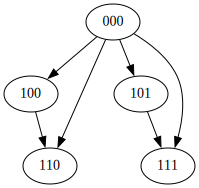

In [4]:
f.dynamics(init=x)

its fully asynchronous dynamics is the following:

# computing graph layout...


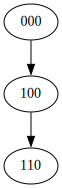

In [5]:
f.dynamics("asynchronous", init=x)

Thus, we can deduce that the MP transition `000 -> 101` has requires a permissive depth strictly greater than 1 (see the method paper for details).

The simulation functions requires as input the list of reachable attractors.
These can be obtained as follows (two fixed point in this example):

In [6]:
A = list(f.attractors(reachable_from=x))
A.sort(key=lambda a: [a[i] for i in f]) # stable ordering, for notebook reproducibility only
tabulate(A)

,a,b,c
0,1,1,0
1,1,1,1


We first estimate their propability in the stationnary distribution from 1,000 simulations of a unform random walk in the full MP dynamics from `x`:

In [7]:
nb_sims = int(1e3)
urw = mpsim.estimate_reachable_attractors_probabilities(f, x, A, nb_sims,
                        depth = mpsim.constant_maximum_depth(f), # full MP dynamics
                        W = mpsim.uniform_rates(f)) # uniform random walk
urw

100%|███████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 7634.96it/s]


{0: 52.1, 1: 47.9}

Let us compare with exponentially decreasing depth and rate...

In [8]:
edw = mpsim.estimate_reachable_attractors_probabilities(f, x, A, nb_sims,
                        depth = mpsim.nexponential_depth(f),
                        W = mpsim.nexponential_rates(f))
edw

100%|███████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4209.22it/s]


{0: 94.9, 1: 5.1}

... and considering only fully-asynchronous transitions:

In [9]:
faw = mpsim.estimate_reachable_attractors_probabilities(f, x, A, nb_sims,
                        depth = mpsim.constant_unitary_depth(f),
                        W = mpsim.fully_asynchronous_rates(f))
faw

100%|███████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6010.25it/s]


{0: 100.0, 1: 0.0}

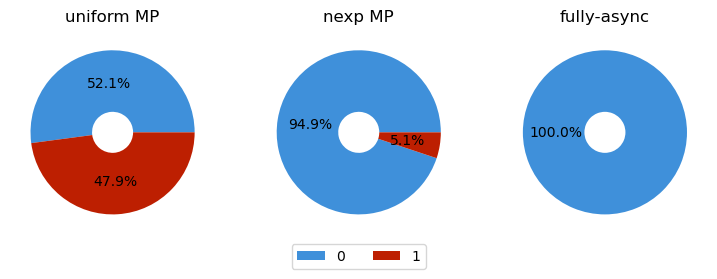

In [10]:
import matplotlib.pyplot as plt

def make_pie(probs, ax=plt):
    labels=[n for n in names if probs.get(n,0) > 0]
    patches, _, _ = ax.pie([probs[n] for n in names if probs.get(n,0) > 0],
                wedgeprops=dict(width=.75),
                colors=[colors[n] for n in names if probs.get(n,0) > 0],
                autopct=lambda pct: f"{pct:.1f}%")
    return dict(zip(labels, patches))
def make_plot(results):
    nb_cols = len(list(results))
    nb_rows = 1
    fig, axes = plt.subplots(nb_rows, nb_cols, figsize=(3*nb_cols, 3*nb_rows))
    patches = {}
    for col, (label, p) in enumerate(results):
        ax = axes[col]
        patches.update(make_pie(p, ax))
        ax.set_title(label)

    axes[1].legend(patches.values(), patches.keys(),
                            bbox_to_anchor=(0.5, -0.2), # Legend position
                            loc='lower center',  
                            ncol=2, 
                            fancybox=True)
names = [0,1]
colors = ["#3f90da",  "#bd1f01"]
make_plot([
    ("uniform MP", urw),
    ("nexp MP", edw),
    ("fully-async", faw)])

## Larger scale model

We demonstrate how to import a model in GINsim format and perform simulations in different mutation conditions.

In [11]:
import ginsim

In [12]:
wt_model = ginsim.load("http://ginsim.org/sites/default/files/SuppMat_Model_Master_Model.zginml")
ginsim.show(wt_model)

/home/pauleve/orga/projects/mpbn/code/examples/SuppMat_Model_Master_Model.zginml

We convert the model to an `mpbn.MPBooleanNetwork` object and define its initial state according to the original publications (all nodes but microRNAs inactives, and DNA damage and ECMicroenv active.

In [13]:
f = mpbn.MPBooleanNetwork(wt_model)
init_active = ["miR200", "miR203", "miR34", "DNAdamage", "ECMicroenv"]
x = {node: node in init_active for node in f}
nb_sims = int(1e3)

We compute the reachable attractors from the initial state. The first two attractors correspond to apoptosis while the latter to metastasis.

In [14]:
A = list(f.attractors(reachable_from=x))
A.sort(key=lambda a: [a[i] for i in f]) # stable ordering, for notebook reproducibility only
tabulate(A)

,AKT1,AKT2,Apoptosis,CDH1,CDH2,CTNNB1,CellCycleArrest,DKK1,DNAdamage,ECMicroenv,EMT,ERK,GF,Invasion,Metastasis,Migration,NICD,SMAD,SNAI1,SNAI2,TGFbeta,TWIST1,VIM,ZEB1,ZEB2,miR200,miR203,miR34,p21,p53,p63,p73
0,0,0,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1
1,0,0,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,1,0,0
2,0,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0


We perform parallel simulations with the specified number of parallel jobs.

In [15]:
mp_wt = mpsim.parallel_estimate_reachable_attractors_probabilities(f, x, A, nb_sims,
                        depth = mpsim.nexponential_depth(f),
                        W = mpsim.nexponential_rates(f), nb_jobs=8)
mp_wt

100%|█████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.98it/s]


{0: 28.8, 1: 51.0, 2: 20.2}

Now, we apply a mutation (p53 loss of function):

In [16]:
f_ko = f.copy()
f_ko["p53"] = 0

We compute the reachable attractors...

In [17]:
A_ko = list(f_ko.attractors(reachable_from=x))
A_ko.sort(key=lambda a: [a[i] for i in f]) # stable ordering, for notebook reproducibility only
tabulate(A_ko)

,AKT1,AKT2,Apoptosis,CDH1,CDH2,CTNNB1,CellCycleArrest,DKK1,DNAdamage,ECMicroenv,EMT,ERK,GF,Invasion,Metastasis,Migration,NICD,SMAD,SNAI1,SNAI2,TGFbeta,TWIST1,VIM,ZEB1,ZEB2,miR200,miR203,miR34,p21,p53,p63,p73
0,0,0,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1
1,0,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0


... in this example, they are a subset of the attractors reachable in the wild type model:

In [18]:
[a in A for a in A_ko]

[True, True]

We perform simulations on the mutated model giving the wild type attractors for make comparison easier.

In [19]:
mp_KO = mpsim.parallel_estimate_reachable_attractors_probabilities(f_ko, x, A, nb_sims,
                        depth = mpsim.nexponential_depth(f),
                        W = mpsim.nexponential_rates(f), nb_jobs=8)
mp_KO

100%|█████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.08it/s]


{0: 60.0, 1: 0.0, 2: 40.0}

We observe that the mutation substantially increases the probability of the metastasis attractor.